# Imports

In [1]:
import pandas as pd
import torch
from google.colab import drive
import os
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import r2_score, mean_squared_error
from torch.nn.utils import clip_grad_norm_

from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import zipfile
import io
import cv2
import numpy as np

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


# Allow for Drive Access

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Basic Preprocessing (may have to change path to run locally)

In [3]:
pth = '/content/drive/MyDrive/18.065 Final Project/Videos Images' # data path where images are stored

for subdir, dirs, files in os.walk(pth):
    for file in files:
        print(os.path.join(subdir, file))

/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/D12EFCD1-B4A1-4572-90FA-71694C070CA7.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/2ABE5B7C-EA75-44AB-9E63-6F751A7AAA3A.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/BB761EFB-59A1-4D78-B575-D06C1D234D70.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/96E31279-96D4-49F9-8633-B46C0D432AC1.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/9AED2DFC-8A4D-4F18-BC4D-0E9A4EA1BCE7.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon 2nd Film/E2C446AF-19A5-4C96-8785-CC52B726F30B.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon 2nd Film/46610F1A-457C-4A31-A791-BC53CB16182C.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon 2nd Film/10CFFEFC-48D7-44C0-9403-F36571FD7B62.zip
/content/drive/MyDrive/18.065 

# Visualize Thermal time series

In [4]:
thermal_df = '/content/drive/MyDrive/18.065 Final Project/CSV Files /thermal_data_truss.csv'
thermal_df = pd.read_csv(thermal_df)
print(len(thermal_df))
thermal_df.head()

9665


,Time_s,ROI1_Temp,ROI2_Temp,Max_Temp,Min_Temp
0,0.000000,119.656863,72.570806,265.0,15.0
1,0.040391,119.656863,72.570806,265.0,15.0
2,0.080782,119.656863,72.570806,265.0,15.0
3,0.121173,119.656863,72.570806,265.0,15.0
4,0.161564,119.656863,72.570806,265.0,15.0


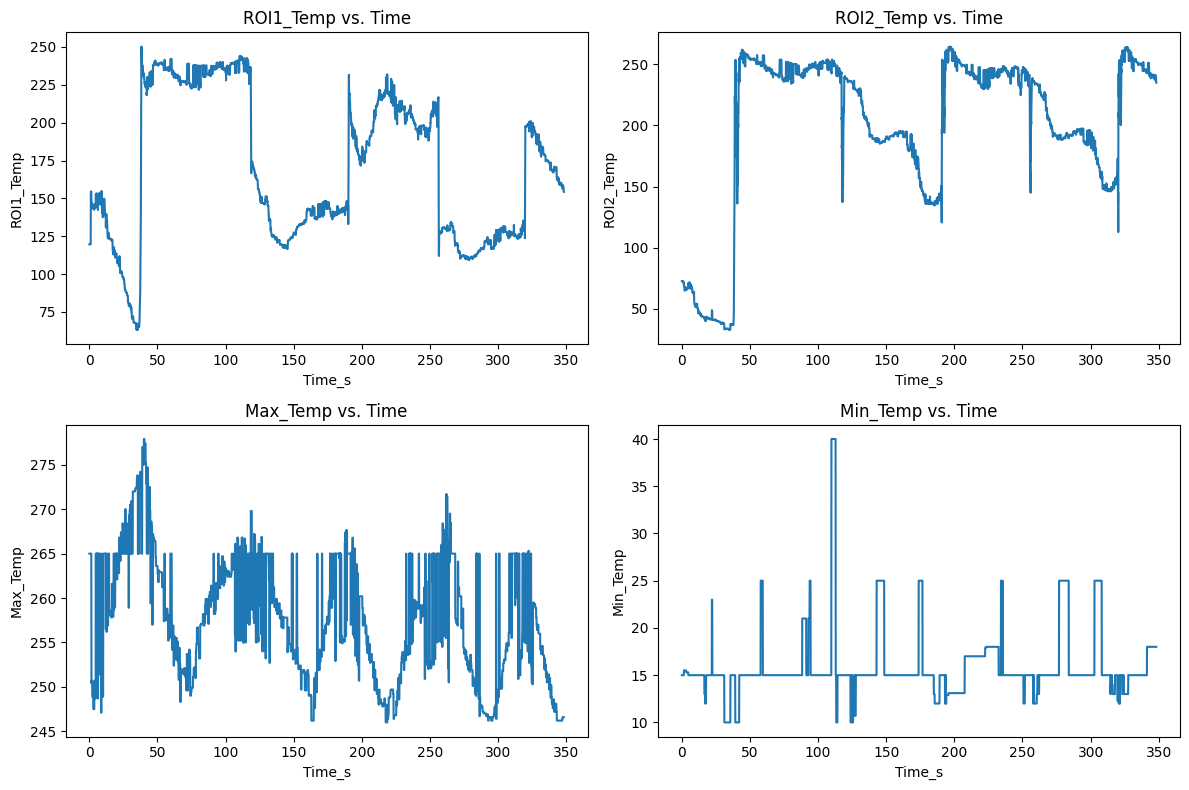

In [5]:
features_to_plot = [col for col in thermal_df.columns if col != 'Time_s']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Adjust figsize as needed

# Iterate through the features and plot them on the subplots
for i, feature in enumerate(features_to_plot[:4]): # Plot only the first four features
    row = i // 2
    col = i % 2
    axes[row, col].plot(thermal_df['Time_s'], thermal_df[feature])
    axes[row, col].set_xlabel('Time_s')
    axes[row, col].set_ylabel(feature)
    axes[row, col].set_title(f'{feature} vs. Time')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Slumping data

In [6]:
slumping_df = pd.read_csv('/content/drive/MyDrive/18.065 Final Project/CSV Files /slumping_data.csv')
slumping_df.head()

,Time_s,ROI1_Temp,ROI2_Temp,Max_Temp,Min_Temp
0,0.000000,148.333333,150.882353,265.0,15.0
1,0.040028,148.333333,150.882353,265.0,15.0
2,0.080055,148.333333,150.882353,265.0,15.0
3,0.120083,148.333333,150.882353,265.0,15.0
4,0.160111,148.333333,150.882353,265.0,15.0


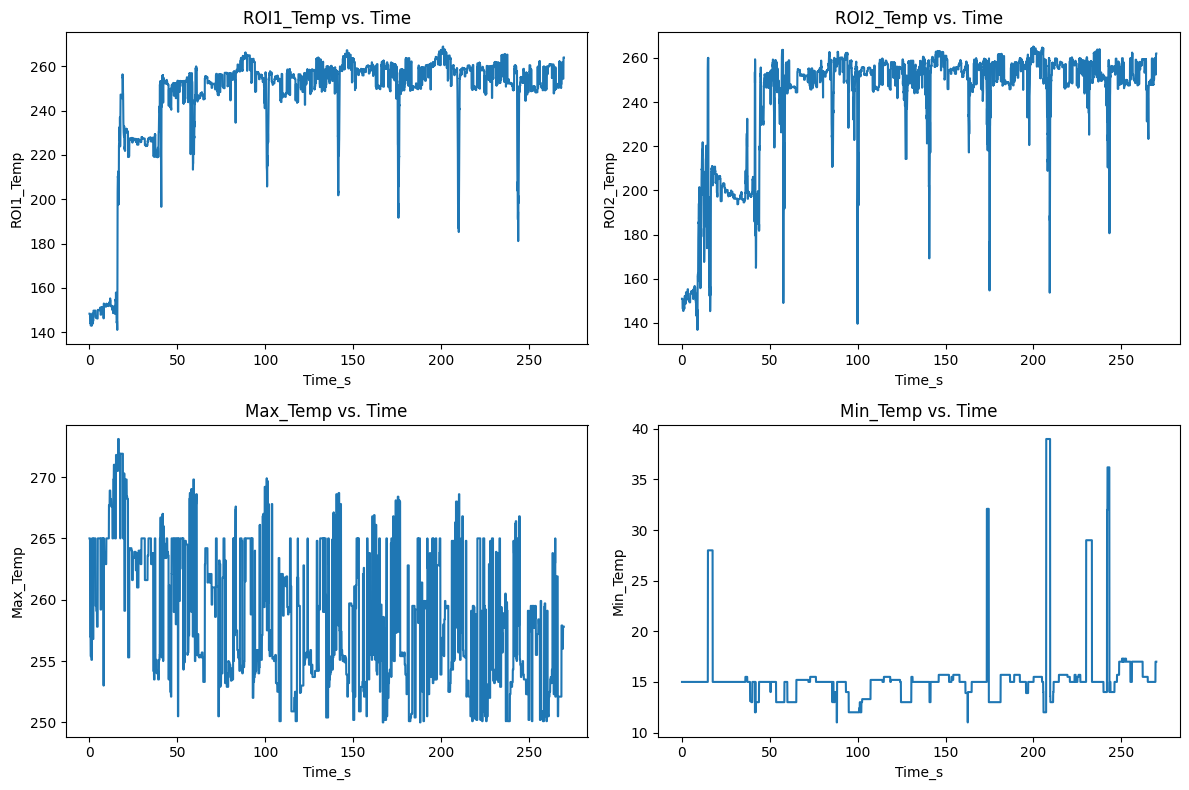

In [7]:
features_to_plot = [col for col in slumping_df.columns if col != 'Time_s']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Adjust figsize as needed

# Iterate through the features and plot them on the subplots
for i, feature in enumerate(features_to_plot[:4]): # Plot only the first four features
    row = i // 2
    col = i % 2
    axes[row, col].plot(slumping_df['Time_s'], slumping_df[feature])
    axes[row, col].set_xlabel('Time_s')
    axes[row, col].set_ylabel(feature)
    axes[row, col].set_title(f'{feature} vs. Time')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Define function for reading in mp4 videos from zip

In [8]:
def open_mp4_video(mp4_path):
  cap = cv2.VideoCapture(mp4_path)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break
    frames.append(frame)
  cap.release()
  return frames

In [9]:
video_pths = ['/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon 2nd Film',
              '/content/drive/MyDrive/18.065 Final Project/Videos Images/3-6 FlexCon 1st',
              '/content/drive/MyDrive/18.065 Final Project/Videos Images/Slumping',
              '/content/drive/MyDrive/18.065 Final Project/Videos Images/Truss']

all_videos = []
for pth in video_pths:
  frames = []
  for subdir, dirs, files in os.walk(pth):
      for file in files:
          if file.endswith('.mp4'):
              frames.append(open_mp4_video(os.path.join(subdir, file)))
  flattened_frames = [frame for sublist in frames for frame in sublist]
  all_videos.append(flattened_frames)

In [10]:
print(len(all_videos))
print(len(all_videos[0]))
assert (all_videos[i][j].shape == (320, 240, 3) for i in range(len(all_videos)) for j in range(len(all_videos[i])))

4
8136


In [11]:
temp_pths = ['/content/drive/MyDrive/18.065 Final Project/CSV Files /FlexCon_34_data.csv',
             '/content/drive/MyDrive/18.065 Final Project/CSV Files /FlexCon_36_data.csv',
             '/content/drive/MyDrive/18.065 Final Project/CSV Files /slumping_data.csv',
             '/content/drive/MyDrive/18.065 Final Project/CSV Files /thermal_data_truss.csv']

all_temps = []
for pth in temp_pths:
  temp = pd.read_csv(pth).drop(columns=['Time_s', 'Max_Temp', 'Min_Temp', 'ROI2_Temp']).values
  all_temps.append(temp)
print(len(all_temps))
print(len(all_temps[0]))

4
8136


In [12]:
# split into train/val datasets
videos_train = []
targets_train = []
videos_val = []
targets_val = []

for video, temp in zip(all_videos, all_temps):
  min_len = min(len(video), len(temp))
  video = video[:min_len]
  temp = temp[:min_len]
  sublists_video = np.array_split(video, 50)
  sublists_temp = np.array_split(temp, 50)
  for i, (video, temp) in enumerate(zip(sublists_video, sublists_temp)):
    if i < 30:
      videos_train.append(video[::5])
      targets_train.append(temp[::5])
    else:
      videos_val.append(video[::5])
      targets_val.append(temp[::5])

# Define model architecture

In [13]:

# --- Patch Embedding ---
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_dim=512, img_size=(320, 240)):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.grid_size = (img_size[1] // patch_size, img_size[0] // patch_size)  # (15, 20)
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, emb_dim))

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x)                      # (B, emb_dim, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)      # (B, num_patches, emb_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, emb_dim)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, num_patches+1, emb_dim)
        return x + self.pos_embed


# --- Transformer Encoder Block ---
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_dim)
        self.attn = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, int(emb_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(emb_dim * mlp_ratio), emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


# --- Minimal ViT Encoder ---
class MiniViTEncoder(nn.Module):
    def __init__(self, img_size=(320, 240), patch_size=16, in_channels=3, emb_dim=512, depth=6, num_heads=8):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_dim, img_size)
        self.blocks = nn.Sequential(*[
            TransformerEncoderBlock(emb_dim, num_heads) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(emb_dim)

    def forward(self, x):
        x = self.patch_embed(x)      # (B, N+1, D)
        x = self.blocks(x)           # (B, N+1, D)
        x = self.norm(x)
        return x[:, 0]               # Use CLS token


# --- Full ViT + LSTM Predictor ---
class ViT_LSTM_Predictor(nn.Module):
    def __init__(self, in_channels=3, feat_dim=512, hidden_dim=256, output_dim=1,
                 num_layers=1, img_size=(320, 240), patch_size=16):
        super().__init__()
        self.encoder = MiniViTEncoder(img_size=img_size, patch_size=patch_size,
                                      in_channels=in_channels, emb_dim=feat_dim)
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.act = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, video):
        B, T, C, H, W = video.shape
        x = video.view(B * T, C, H, W)     # Already correct shape
        feats = self.encoder(x).view(B, T, -1)
        lstm_out, _ = self.lstm(feats)
        h = self.act(lstm_out)
        out = self.output_layer(h)
        return out


# He (Kaiming) initialization function

def init_weights_he(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [14]:
torch.cuda.empty_cache()

In [15]:
model = ViT_LSTM_Predictor(output_dim = 1)

In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class VideoWindowDataset(Dataset):
    def __init__(self, videos, targets, window_size, stride, summary_fn):
        """
        videos: list of (T_i, C, H, W) arrays
        targets: list of (T_i, D) arrays
        window_size, stride: ints
        summary_fn: fn that maps a (window_size, D) array -> scalar
        """
        self.windows = []
        for vid, tgt in zip(videos, targets):
            T = vid.shape[0]
            # slide a window of length window_size
            for start in range(0, T - window_size + 1, stride):
                end = start + window_size
                v_win = vid[start:end]          # (window_size, C, H, W)
                t_win = tgt[start:end]          # (window_size, D)
                s_val = summary_fn(t_win)       # scalar
                self.windows.append((v_win, t_win, s_val))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        # v, t, s = self.windows[idx]
        # return torch.from_numpy(v).float(), torch.from_numpy(t).float(), s
        v, t, s = self.windows[idx]
        # apply log to the targets (assuming t > 0 everywhere)
        eps = 1e-6
        # Check if t is already a tensor
        if isinstance(t, torch.Tensor):
            t_log = torch.log(t.float() + eps)  # Use t directly if it's a tensor
        else:
            t_log = torch.log(torch.from_numpy(t).float() + eps) # Otherwise, convert to tensor
        # Check if v is already a tensor, if so, use it directly
        # If it's not, convert it using torch.from_numpy
        if isinstance(v, torch.Tensor):
            v = v.float()
        else:
            v = torch.from_numpy(v).float()
        return (
            v, # Return v directly if it's already a tensor
            t_log,
            s  # you can still use the original summary_fn (or its log‐version)
        )

# 1) Build the dataset
def mean_summary(t_win):
    return float(t_win.mean())  # or .mean(axis=0)[0], etc.

ds = VideoWindowDataset(
    videos=videos_train,
    targets=targets_train,
    window_size=20,
    stride=5,
    summary_fn=mean_summary
)

# 2) Compute histogram over all s_vals
all_s = np.array([s for _,_,s in ds.windows])
bins = np.linspace(all_s.min(), all_s.max(), 50)
bin_idx = np.digitize(all_s, bins)
counts = np.bincount(bin_idx, minlength=len(bins)+1)

# 3) Compute sample weights ∝ 1 / count[bin]
weights = 1.0 / counts[bin_idx]
weights = torch.tensor(weights, dtype=torch.double)

# 4) Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),
    replacement=True
)

# 5) DataLoader
loader = DataLoader(
    ds,
    batch_size=8,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)


# Set up Training loop

In [17]:
class VideoDataset(Dataset):
    def __init__(self, videos, targets):
        """
        videos: list or array of shape (N, T, C, H, W)
        targets: list or array of shape (N, T, output_dim)
        """
        self.videos = videos
        self.targets = targets

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        # Return one sample: video tensor and corresponding target tensor
        video = torch.tensor(self.videos[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)

        return video, target

# Assume videos_train, targets_train, videos_val, targets_val are prepared numpy arrays or similar
val_dataset   = VideoDataset(videos_val, targets_val)


val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Updated training loop with per-sample loss weighting
criterion = nn.L1Loss(reduction='none')  # we'll compute per-element errors
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 50
log_interval = 26

min_grad_warning = 1e-6
max_grad_norm = 10.0

for epoch in range(1, num_epochs + 1):
    print(f'On epoch {epoch}')
    model.train()
    running_loss = 0.0

    for batch_idx, (videos, targets, weights) in enumerate(loader, start=1):
        videos, targets, weights = videos.to(device), targets.to(device), weights.to(device)

        optimizer.zero_grad()
        videos = videos.permute(0, 1, 4, 2, 3)
        outputs = model(videos)

        # compute weighted MSE loss (example for MSELoss(reduction='none'))
        se = criterion(outputs, targets)                    # (B, T, D)
        mse_per_sample = se.view(se.size(0), -1).mean(dim=1) # (B,)
        loss = (mse_per_sample * weights).sum() / weights.sum()
        # loss = criterion(outputs, targets).mean()

        loss.backward()

        # Gradient clipping
        total_norm = clip_grad_norm_(model.parameters(), max_grad_norm)
        if total_norm < min_grad_warning:
            print(f"Warning: low gradient norm {total_norm:.2e} at epoch {epoch}, batch {batch_idx}")

        optimizer.step()
        running_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(f"[Epoch {epoch}][{batch_idx}/{len(loader)}] "
                  f"Train Loss: {loss.item():.4f}, Grad Norm: {total_norm:.2f}")

    avg_train_loss = running_loss / len(loader)
    print(f"Epoch {epoch} Training Loss: {avg_train_loss:.4f}\n")

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for videos, targets in val_loader:
            videos  = videos.to(device)
            targets = targets.to(device)
            # outputs = model(videos)
            videos = videos.permute(0, 1, 4, 2, 3)
            outputs = torch.exp(model(videos))
            val_loss += criterion(outputs, targets).mean().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch} Validation Loss: {avg_val_loss:.4f}\n")

On epoch 1
[Epoch 1][26/53] Train Loss: 2.7892, Grad Norm: 7.79
[Epoch 1][52/53] Train Loss: 2.1130, Grad Norm: 9.11
Epoch 1 Training Loss: 2.8633

Epoch 1 Validation Loss: 189.7969

On epoch 2
[Epoch 2][26/53] Train Loss: 1.6698, Grad Norm: 9.46
[Epoch 2][52/53] Train Loss: 1.1282, Grad Norm: 8.24
Epoch 2 Training Loss: 1.6315

Epoch 2 Validation Loss: 164.7693

On epoch 3
[Epoch 3][26/53] Train Loss: 1.0921, Grad Norm: 9.04
[Epoch 3][52/53] Train Loss: 0.4435, Grad Norm: 7.60
Epoch 3 Training Loss: 1.0290

Epoch 3 Validation Loss: 129.0398

On epoch 4
[Epoch 4][26/53] Train Loss: 0.6327, Grad Norm: 9.66
[Epoch 4][52/53] Train Loss: 0.4060, Grad Norm: 7.01
Epoch 4 Training Loss: 0.6377

Epoch 4 Validation Loss: 84.4945

On epoch 5
[Epoch 5][26/53] Train Loss: 0.4488, Grad Norm: 8.26
[Epoch 5][52/53] Train Loss: 0.3016, Grad Norm: 0.61
Epoch 5 Training Loss: 0.4235

Epoch 5 Validation Loss: 52.4603

On epoch 6
[Epoch 6][26/53] Train Loss: 0.3957, Grad Norm: 0.55
[Epoch 6][52/53] Train 

KeyboardInterrupt: 

# Some test evaluation

In [18]:
model.eval()
all_targets = []
all_predictions = []
val_dataset   = VideoDataset(videos_val, targets_val)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
with torch.no_grad():
    for videos, targets, in val_loader:
        videos = videos.to(device)
        targets = targets.to(device)
        videos = videos.permute(0, 1, 4, 2, 3)
        outputs = torch.exp(model(videos))
        all_targets.extend(targets.cpu().numpy().flatten())
        all_predictions.extend(outputs.cpu().numpy().flatten())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
mask = (all_predictions != 0.0) & (all_targets != 0.0)
filtered_all_predictions = all_predictions[mask]
filtered_all_targets_r2 = all_targets[mask]

r2 = r2_score(filtered_all_targets_r2, filtered_all_predictions)
rmse = np.sqrt(mean_squared_error(filtered_all_targets_r2, filtered_all_predictions))

print(f"R^2 on validation set: {r2:.4f}")
print(f"RMSE on validation set: {rmse:.4f}")

R^2 on validation set: -0.4295
RMSE on validation set: 50.1530


# Plot/Visualization for presentation

80


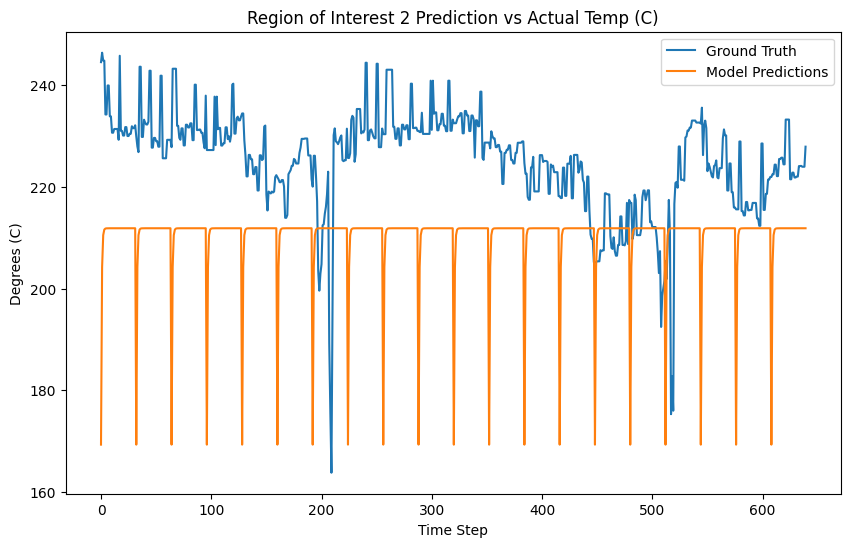

In [20]:
# prompt: plot the model outputs of the first video in the validation set with the ground truth values

# Assuming 'val_loader' and 'model' are defined as in your provided code.
# Also assuming 'device' is defined.

model.eval()
all_outputs = []
all_targets = []
print(len(val_loader))
for i, (videos, targets) in enumerate(val_loader):
    if i in range(20):  # Process only the first video in the validation set
      videos = videos.to(device)
      videos = videos.permute(0, 1, 4, 2, 3)
      targets = targets.to(device)
      with torch.no_grad():
          outputs = model(videos)

      # Convert tensors to numpy arrays
      outputs = torch.exp(outputs.cpu().squeeze()[1:]).numpy()
      targets = targets.cpu().squeeze().numpy()[1:]


      all_outputs += [outputs[i] for i in range(len(outputs))]
      all_targets += [targets[i] for i in range(len(targets))]

    # else:
    #     break

all_outputs = np.array(all_outputs)
all_targets = np.array(all_targets)
mask = (all_outputs != 0.0) & (all_targets != 0.0)
filtered_all_outputs = all_outputs[mask]
filtered_all_targets = all_targets[mask]
plt.figure(figsize=(10, 6))
plt.plot(filtered_all_targets, label='Ground Truth')
plt.plot(filtered_all_outputs, label='Model Predictions')
plt.xlabel('Time Step')
plt.ylabel('Degrees (C)')
plt.title('Region of Interest 2 Prediction vs Actual Temp (C)')
plt.legend()
plt.show()

In [ ]:
outputs_roi_1 = pd.DataFrame(filtered_all_outputs, columns = ['ROI2_Temp'])
outputs_roi_1.to_csv('outputs_roi_2.csv')

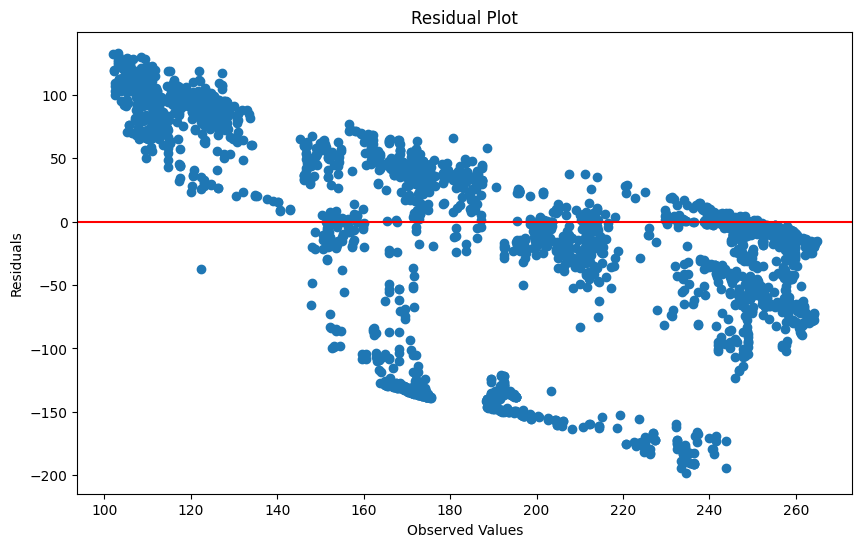

In [42]:
# prompt: make a residual plot of filtered_all_predictions and filtered_all_targets_r2

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(filtered_all_targets_r2, filtered_all_predictions - filtered_all_targets_r2)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel("Observed Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()
